# MNIST Dataset with CNN Project

This project is using [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset).
### MNIST Dataset description:

> The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. .

In this notebook I am going to load and explore the MNIST data, put the images into batches, define an CNN model, train the model and finally evaluate it in the following specific steps:

0. Make imports
1. Load and examine the MNIST data
2. Define the model
3. Train the model
4. Evaluate the model (use test data)

## 0. Make imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load and examine the MNIST data

### 1.1 Define transform

In [85]:
# before loading the dataset I am going to define transform in order to transform images to tensors

transform = transforms.ToTensor()

### 1.2 Load the MNIST dataset

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

/Users/aga/opt/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### 1.5 Put images into batches

In [56]:
#When working with images, we want relatively small batches; a batch size of 4 is not uncommon.
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

### 1.6 Define a convolutional model

The model follows: **CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.**

In [57]:
# Define layers
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,18,3,1)

In [86]:
# The first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [59]:
X_train.shape

torch.Size([1, 28, 28])

In [60]:
x = X_train.view(1,1,28,28)

In [61]:
x = F.relu(conv1(x)) 

In [62]:
x.shape
# it is 26x26, beacause while putting it through kernel 3x3 we might lose some info on the borders if our padding is 0

torch.Size([1, 6, 26, 26])

In [63]:
x = F.max_pool2d(x,2,2)#x,kernel_size,stride_size

In [64]:
x.shape
#it is 13x13 because of 2x2 kernel

torch.Size([1, 6, 13, 13])

In [65]:
x = F.relu(conv2(x))

In [66]:
x.shape

torch.Size([1, 18, 11, 11])

In [67]:
x = F.max_pool2d(x,2,2)

In [68]:
x.shape

torch.Size([1, 18, 5, 5])

In [87]:
# Flatten the data
x.view(-1,18*5*5).shape

torch.Size([1, 450])

## 2. Define the model

### 2.1 Define the CNN class

In [71]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,18,3,1)
        self.fc1 = nn.Linear(5*5*18,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10) # output must be 10 because of 10 classes
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,18*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [72]:
torch.manual_seed(24)
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=450, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 2.2 Count the model parameters

In [89]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [90]:
count_parameters(model)

    54
     6
   972
    18
 54000
   120
 10080
    84
   840
    10
______
 66184


### 2.3 Define the loss function and optimizer

In [91]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)

## 3. Train the model

### 3.1 Train

In [95]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            


epoch:  0  batch: 600 [  6000/60000]  loss: 0.00000044  accuracy:  99.250%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.00001744  accuracy:  99.292%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.00129187  accuracy:  99.267%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.08094945  accuracy:  99.242%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00000424  accuracy:  99.233%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00000523  accuracy:  99.261%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00002407  accuracy:  99.257%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00089778  accuracy:  99.258%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00466387  accuracy:  99.248%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00614653  accuracy:  99.227%
epoch:  1  batch: 600 [  6000/60000]  loss: 0.00013806  accuracy:  99.567%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00009697  accuracy:  99.450%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00036842  accuracy:  99.378%
epoch:  1  bat

### 3.2 Plot the loss and accuracy comparisons

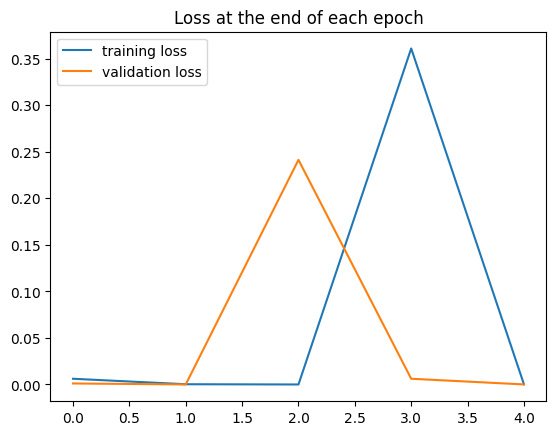

In [96]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

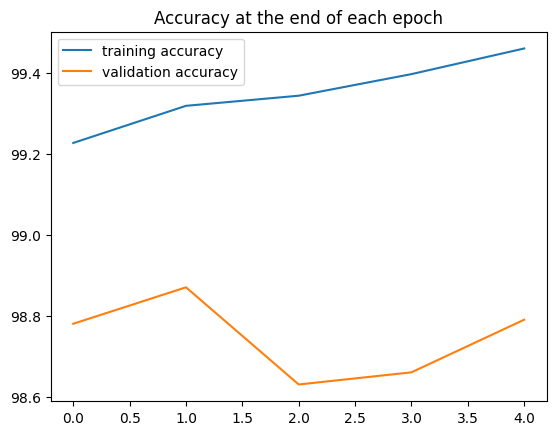

In [97]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## 4.Evaluate the model (use test data)

### 4.1 Show the test scores

In [98]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [99]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9879/10000 =  98.790%


### 4.2 Display the confusion matrix

In [100]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 970    0    0    0    1    2    3    0    1    1]
 [   0 1124    0    0    0    0    2    2    0    1]
 [   3    0 1028    3    1    0    2    9    3    0]
 [   0    1    0 1003    0    7    0    2    2    2]
 [   1    1    0    0  967    0    1    2    1    6]
 [   0    3    0    2    0  876    1    0    0    4]
 [   2    4    1    0    3    2  946    0    0    0]
 [   1    1    3    1    1    1    0 1009    0    0]
 [   3    1    0    1    2    0    3    2  964    3]
 [   0    0    0    0    7    4    0    2    3  992]]


### 4.3 Examine the misses

In [101]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

121

In [102]:
# Display the first 10 index positions
misses[:10]

array([  92,  340,  406,  448,  449,  495,  557,  582,  619,  646])

In [103]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [  92  340  406  448  449  495  557  582  619  646  659]
Label: [   9    5    5    9    3    8    7    8    1    2    2]
Guess: [   4    3    9    8    5    2    2    2    8    6    7]


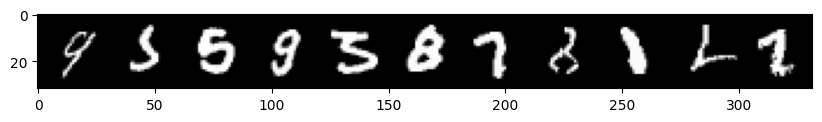

In [104]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));